# Project 4

I have used ChatGPT and Github Copilot for guidence and faster development

In [ ]:
!%pip install networkx matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import zipfile
import requests
import tempfile
import os
import numpy as np
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
import seaborn as sns
from scipy import stats
import networkit as nk
#!pip install powerlaw
import powerlaw


zsh:fg:1: no job control in this shell.


Ex1 Import the data, draw their histogram.


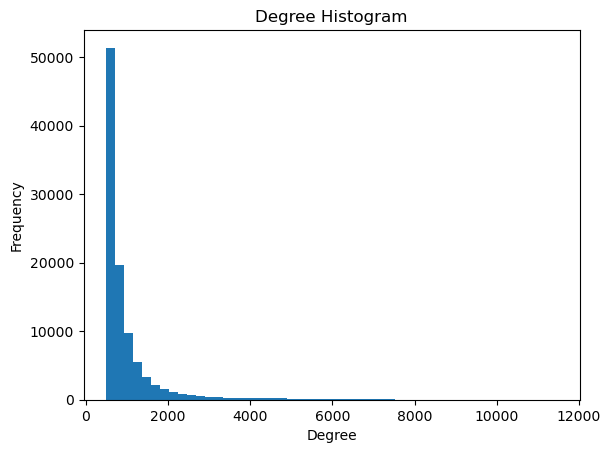

In [20]:
num_nodes = 100000
ba_m = 500
ba_graph = nx.barabasi_albert_graph(num_nodes, ba_m)
degrees = [ba_graph.degree(n) for n in ba_graph.nodes()]
plt.hist(degrees, bins=50)
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


Ex2 Correct the scale of the plot's axes to double logaritmic.


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


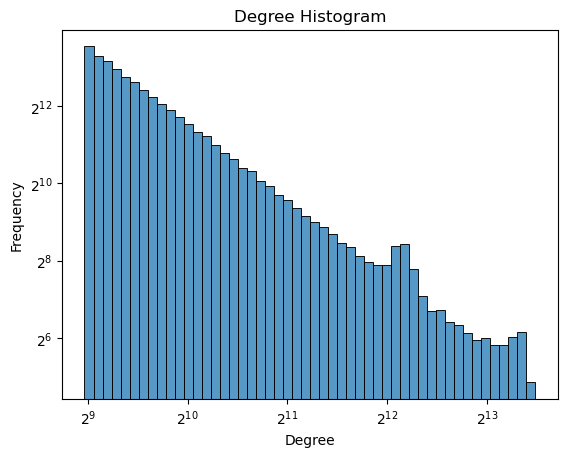

In [27]:
degree_df = pd.DataFrame(degrees, columns=['Degree'])
max_degree = max(degrees)
bins = np.logspace(0, np.log2(max_degree), num=20, base=2)

sns.histplot(degree_df, x='Degree', bins=50, log_scale=(2, 2)) # double logaritmic scale
#plt.xscale('log', base=2)
#plt.yscale('log', base=2)
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Ex3 Apply logarithmic binning as well.


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


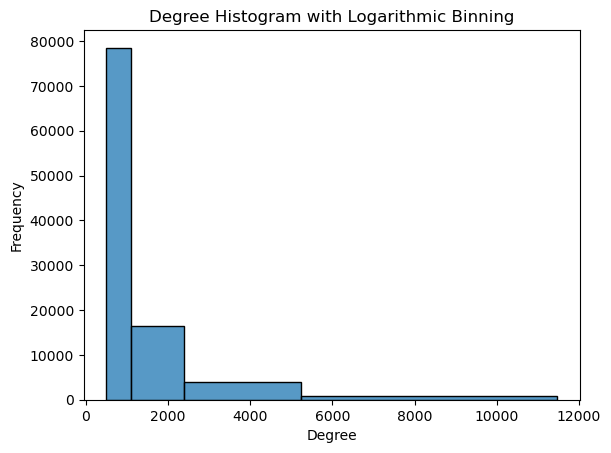

In [41]:
degree_df = pd.DataFrame(degrees, columns=['Degree'])
max_degree = max(degrees)
min_degree = max(min(degrees), 1)

sns.histplot(degree_df, x='Degree', bins=np.logspace(np.log10(min_degree), np.log10(max_degree), num=5)) #TODO: scale log base 2
plt.title("Degree Histogram with Logarithmic Binning")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Ex4 Compute and draw the survival function.


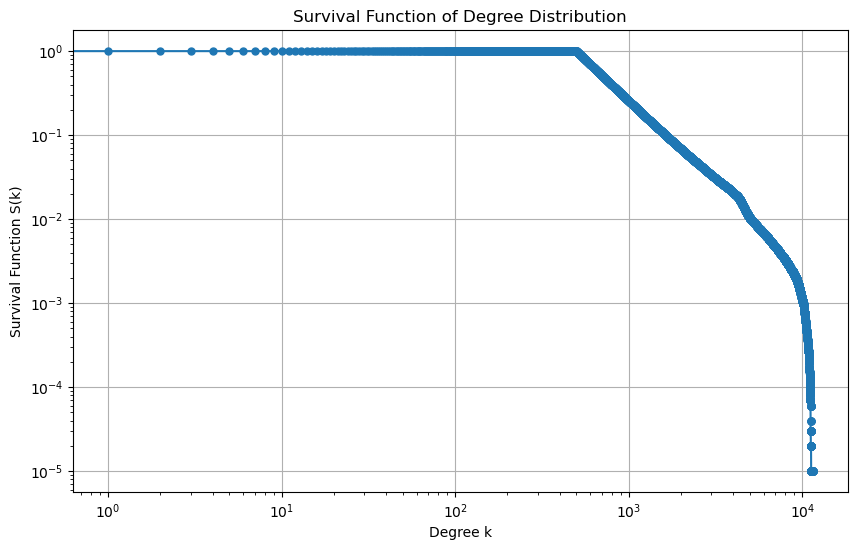

In [58]:
degrees = [deg for _, deg in ba_graph.degree()]

degree_counts = np.bincount(degrees) 
total_nodes = len(ba_graph.nodes) # n

degree_range = np.arange(len(degree_counts))
survival_function = np.array([sum(degree_counts[k:]) / total_nodes for k in degree_range])

plt.figure(figsize=(10, 6))
plt.loglog(range(len(survival_function)), survival_function, marker='o', linestyle='-', markersize=5)
plt.xlabel('Degree k')
plt.ylabel('Survival Function S(k)')
plt.title('Survival Function of Degree Distribution')
plt.grid(True)
plt.show()

Ex5 Which chart is the most readable? Which is most robust for the noise?


Ex6 Use the linear regression to the previous plots to determine the parameter a estimator.


Estimated alpha (α): 2.9185


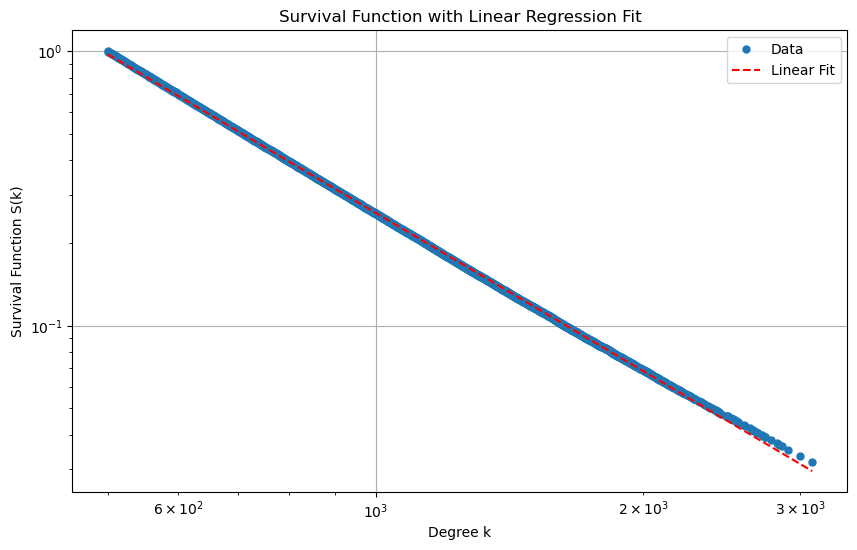

In [104]:
x_min = 5
valid = (degree_counts[degree_range] > x_min)
k = degree_range[valid]
S_k = survival_function[valid]

log_k = np.log10(k)
log_S_k = np.log10(S_k)

slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_S_k)

# Estimate alpha
alpha = 1 - slope

# Print the results
print(f"Estimated alpha (α): {alpha:.4f}")

plt.figure(figsize=(10, 6))
plt.loglog(k, S_k, marker='o', linestyle='', markersize=5, label='Data')
plt.loglog(k, 10**(intercept + slope * log_k), linestyle='--', color='red', label='Linear Fit')
plt.xlabel('Degree k')
plt.ylabel('Survival Function S(k)')
plt.title('Survival Function with Linear Regression Fit')
plt.legend()
plt.grid(True)
plt.show()

Ex7 Compute (formula and value for our data) MLE estimator for a with a known x_min assuming continous power distribution.



$$
P(x) = \frac{a - 1}{x_{\text{min}}} \left( \frac{x}{x_{\text{min}}} \right)^{-a}
$$


$$
L(a) = \prod_{i=1}^n P(x_i) = \prod_{i=1}^n \frac{a - 1}{x_{\text{min}}} \left( \frac{x_i}{x_{\text{min}}} \right)^{-a}
$$


$$
\ell(a) = \sum_{i=1}^n \log \left( \frac{a - 1}{x_{\text{min}}} \left( \frac{x_i}{x_{\text{min}}} \right)^{-a} \right)
$$


$$
\ell(a) = \sum_{i=1}^n \left( \log(a - 1) - \log(x_{\text{min}}) - a \log \left( \frac{x_i}{x_{\text{min}}} \right) \right)
$$


$$
\ell(a) = n \log(a - 1) - n \log(x_{\text{min}}) - a \sum_{i=1}^n \log \left( \frac{x_i}{x_{\text{min}}} \right)
$$

$$
\frac{d\ell(a)}{da} = \frac{n}{a - 1} - \sum_{i=1}^n \log \left( \frac{x_i}{x_{\text{min}}} \right) = 0
$$

$$
\frac{n}{a - 1} = \sum_{i=1}^n \log \left( \frac{x_i}{x_{\text{min}}} \right)
$$

$$
a - 1 = \frac{n}{\sum_{i=1}^n \log \left( \frac{x_i}{x_{\text{min}}} \right)}
$$

$$
a = 1 + \frac{n}{\sum_{i=1}^n \log \left( \frac{x_i}{x_{\text{min}}} \right)}
$$



$$
\hat{a} = 1 + \frac{n}{\sum_{i=1}^n \log \left( \frac{x_i}{x_{\text{min}}} \right)}
$$


In [117]:
def mle_estimator(x_min):
    filtered_degrees = degrees[degrees >= x_min]

    n  = len(filtered_degrees)
    log_ratios = np.log(filtered_degrees / x_min)

    alpha_hat = 1 + n / np.sum(log_ratios)

    print(f"MLE Estimator(x_min = {x_min}) for alpha (α): {alpha_hat:.4f}")
    return alpha_hat
mle_estimator(5)

MLE Estimator(x_min = 5) for alpha (α): 3.1602


3.160244605913668

Ex8 How will the result change if we do not know x_min?


In [ ]:
for x_min in range(1, 100):
    mle_estimator(x_min)

P4.1 Collect obtained scripts for power distribution in one file. We will use them again and again.

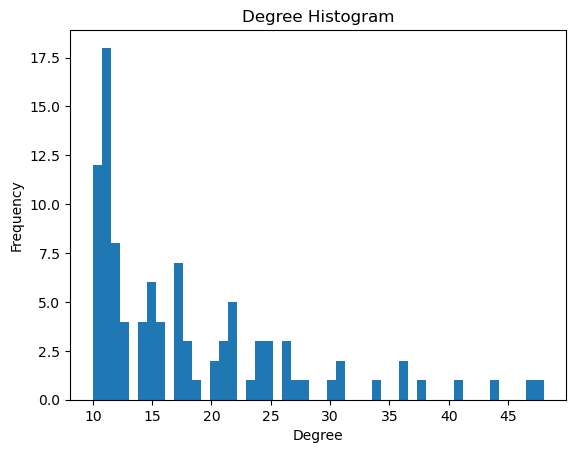

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


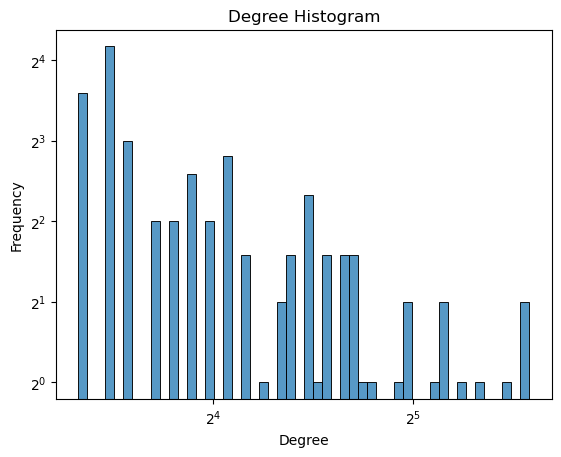

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


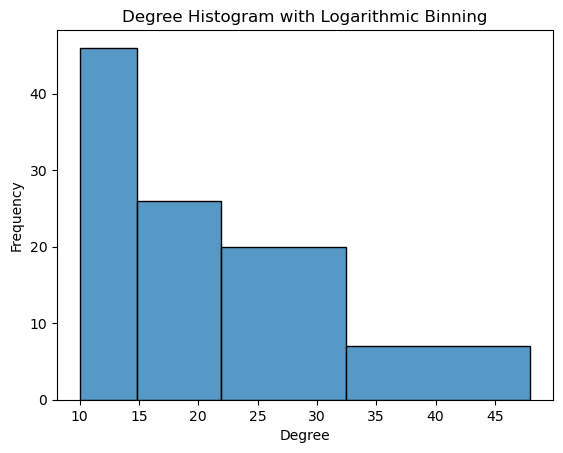

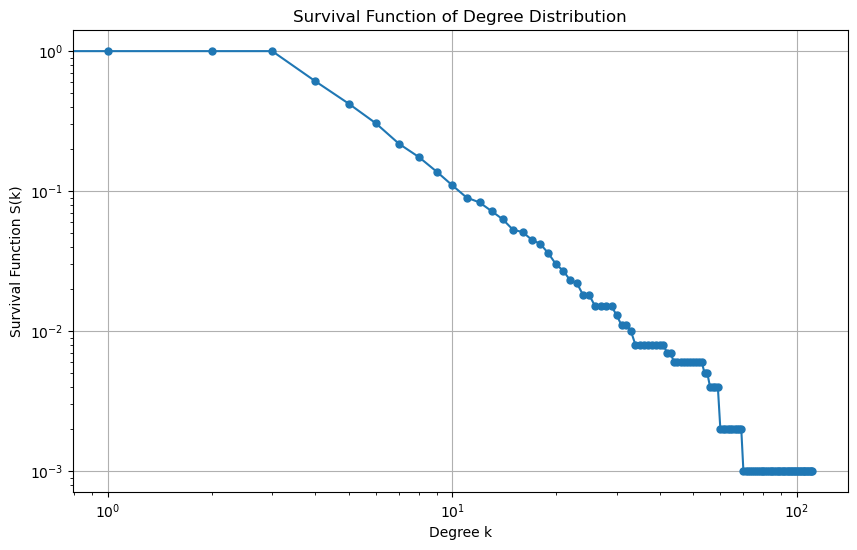

Estimated alpha (α): 2.8077


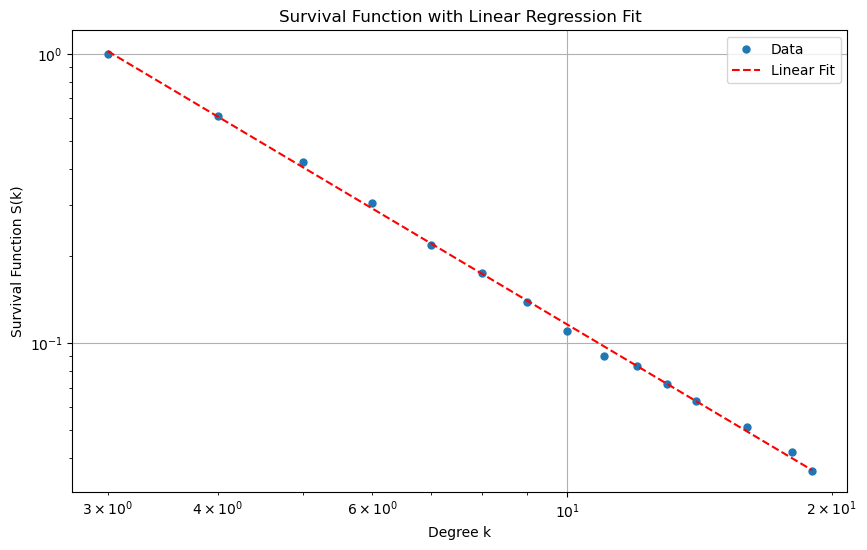

MLE Estimator(x_min = 5) for alpha (α): 3.1602


In [122]:
def analyze(degrees, x_min):
    # Ex1
    plt.hist(degrees, bins=50)
    plt.title("Degree Histogram")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()
    
    # Ex2
    degree_df = pd.DataFrame(degrees, columns=['Degree'])
    max_degree = max(degrees)
    bins = np.logspace(0, np.log2(max_degree), num=20, base=2)

    sns.histplot(degree_df, x='Degree', bins=50, log_scale=(2, 2)) # double logaritmic scale
    #plt.xscale('log', base=2)
    #plt.yscale('log', base=2)
    plt.title("Degree Histogram")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Ex3
    degree_df = pd.DataFrame(degrees, columns=['Degree'])
    max_degree = max(degrees)
    min_degree = max(min(degrees), 1)

    sns.histplot(degree_df, x='Degree', bins=np.logspace(np.log10(min_degree), np.log10(max_degree), num=5)) #TODO: scale log base 2
    plt.title("Degree Histogram with Logarithmic Binning")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Ex4
    degrees = np.array([deg for _, deg in ba_graph.degree()])

    degree_counts = np.bincount(degrees) 
    total_nodes = len(ba_graph.nodes) # n

    degree_range = np.arange(len(degree_counts))
    survival_function = np.array([sum(degree_counts[k:]) / total_nodes for k in degree_range])

    plt.figure(figsize=(10, 6))
    plt.loglog(range(len(survival_function)), survival_function, marker='o', linestyle='-', markersize=5)
    plt.xlabel('Degree k')
    plt.ylabel('Survival Function S(k)')
    plt.title('Survival Function of Degree Distribution')
    plt.grid(True)
    plt.show()

    # Ex 6
    x_min = 5
    valid = (degree_counts[degree_range] > x_min)
    k = degree_range[valid]
    S_k = survival_function[valid]

    log_k = np.log10(k)
    log_S_k = np.log10(S_k)

    slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_S_k)

    # Estimate alpha
    alpha = 1 - slope

    # Print the results
    print(f"Estimated alpha (α): {alpha:.4f}")

    plt.figure(figsize=(10, 6))
    plt.loglog(k, S_k, marker='o', linestyle='', markersize=5, label='Data')
    plt.loglog(k, 10**(intercept + slope * log_k), linestyle='--', color='red', label='Linear Fit')
    plt.xlabel('Degree k')
    plt.ylabel('Survival Function S(k)')
    plt.title('Survival Function with Linear Regression Fit')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Ex 7
    def mle_estimator(x_min):
        filtered_degrees = degrees[degrees >= x_min]

        n  = len(filtered_degrees)
        log_ratios = np.log(filtered_degrees / x_min)

        alpha_hat = 1 + n / np.sum(log_ratios)

        print(f"MLE Estimator(x_min = {x_min}) for alpha (α): {alpha_hat:.4f}")
        return alpha_hat
    
    mle_estimator(x_min)

test = nx.barabasi_albert_graph(100, 10)
analyze([test.degree(n) for n in test.nodes()], x_min)



P4.2 Prove that for uncorrelated newtwork k_nn(k_i)= k^2/k


$$ P(k \mid k_i) = \frac{k * P(k)}{\langle k \rangle} $$




$$ \begin{align*} \langle k \rangle_{\text{nn}}(k_i) &= \sum_k k * P(k \mid k_i) \ &= \sum_k k * P_{\text{edge}}(k) \ &= \sum_k k \left( \frac{k * P(k)}{\langle k \rangle} \right) \ &= \frac{1}{\langle k \rangle} \sum_k k^2 P(k) \ &= \frac{\langle k^2 \rangle}{\langle k \rangle} \end{align*} $$



P4.3 Determin the dependence of the average degree of the nearest neighbor on the degree of the vertex for selected real or artificial networks

P4.4 Check how random edge switching affects the result of the previous task

In [2]:
import random

def random_edge_switching(graph, num_switches):
    nk_graph = nk.nxadapter.nx2nk(graph)
    edgeswitch = nk.randomization.EdgeSwitching(nk_graph, num_switches)
    edgeswitch.run()
    graph_copy = edgeswitch.getGraph()
    return nk.nxadapter.nk2nx(graph_copy)



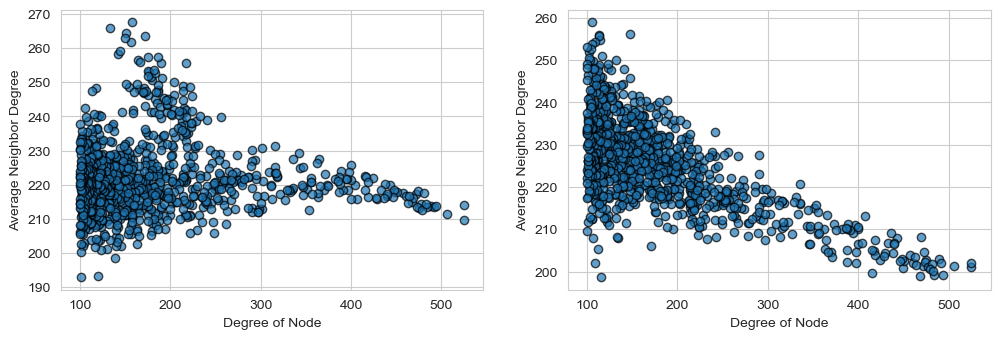

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def average_neighbor_degree(G, ax):
    avg_neighbor_degree_values = nx.average_neighbor_degree(G)
    degree_values = dict(G.degree())

    node_degrees = list(degree_values.values())
    avg_neighbor_degrees = list(avg_neighbor_degree_values.values())

    #sns.scatterplot(x=node_degrees, y=avg_neighbor_degrees)
    ax.scatter(node_degrees, avg_neighbor_degrees, alpha=0.7, edgecolors='k')
    ax.set_xlabel("Degree of Node")
    ax.set_ylabel("Average Neighbor Degree")
    return ax



G = nx.barabasi_albert_graph(1000, 100)
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(2, 2, 1)
ax = average_neighbor_degree(G, ax)
ax = fig.add_subplot(2, 2, 2)

n_swaps = len(G.nodes())
G_switched = random_edge_switching(G, n_swaps)

ax = average_neighbor_degree(G_switched, ax)
plt.show()

P4.5 Make the derivation omitted on the lecture slide.

P4.6 Find the correlation coefficient for the network from task 4.3-4.4 (before and after the random edge switching).

In [17]:
print(f"Correlation between degree and average neighbor degree in the original graph: {nx.degree_assortativity_coefficient(G)}")
print(f"Correlation between degree and average neighbor degree in the switched graph: {nx.degree_assortativity_coefficient(G_switched)}")

Correlation between degree and average neighbor degree in the original graph: -0.012357113622391398
Correlation between degree and average neighbor degree in the switched graph: -0.08184743013505333


P4.7 Let's fil the above table with metrics of selected real networks, use the built-in functions for counting the parameters. Compare the results with the literature.

In [16]:
def calculate_stats(graph):
    directed = nx.is_directed(graph)

    n = graph.number_of_nodes()

    e = graph.number_of_edges()

    avg_deg = np.mean([d for n, d in graph.degree()])

    degrees = [d for n, d in graph.degree()]
    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.power_law.alpha

    if nx.is_connected(graph):
        mean_length = nx.average_shortest_path_length(graph)
    else:
        mean_length = -1

    correlation_coefficient = nx.degree_pearson_correlation_coefficient(graph)

    return {
        "is_directed": directed,
        "num_nodes": n,
        "num_edges": e,
        "avg_degree": avg_deg,
        "alpha": alpha,
        "mean_shortest_path_length": mean_length,
        "correlation_coefficient": correlation_coefficient,
    }


graphs = {
    "BA example": G,
    "BA switched": G_switched,
    'Karate Club': nx.karate_club_graph(),
    'Watts-Strogatz': nx.watts_strogatz_graph(100, 6, 0.3),
    'Barabási-Albert': nx.barabasi_albert_graph(100, 3),
    'Random Geometric': nx.random_geometric_graph(100, 0.2),
    'Erdős-Rényi': nx.erdos_renyi_graph(100, 0.05)
}

# Calculate stats for each graph and store in a list
stats = [calculate_stats(G) for G in graphs.values()]

# Create a DataFrame to hold the stats for each graph
stats_df = pd.DataFrame(stats, index=graphs.keys())

# Display the resulting DataFrame
stats_df


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


,is_directed,num_nodes,num_edges,avg_degree,alpha,mean_shortest_path_length,correlation_coefficient
BA example,False,1000,90000,180.000000,3.754571,1.819820,-0.012357
BA switched,False,1000,90000,180.000000,3.754571,1.819820,-0.081847
Karate Club,False,34,78,4.588235,2.094307,2.408200,-0.475613
Watts-Strogatz,False,100,300,6.000000,11.640077,2.939596,-0.002293
Barabási-Albert,False,100,291,5.820000,2.498926,2.595960,-0.106363
Random Geometric,False,100,506,10.120000,9.675732,3.854343,0.594423
Erdős-Rényi,False,100,226,4.520000,5.204025,-1.000000,0.082783


11.640077	cannot compute 

P4.8 Analyse the data on the ENP website. Draw histograms of the Erdos number for the Nobel prize and the Fields medal laureates.


> In this paper, the authors show, among other things, that all Fields Medal winners through 1998 have Erdös numbers less than 6 and that at least 63 Nobel prize winners have Erdös numbers less than 9. Here is the primary reference list for the Mathematical Intelligencer paper.

https://www.csauthors.net/przemyslaw-biecek/

https://sites.google.com/oakland.edu/grossman/home/the-erdoes-number-project/some-famous-people-with-finite-erdoes-numbers/wolf-prize-in-mathematics-winners?authuser=0

https://sites.google.com/oakland.edu/grossman/home/the-erdoes-number-project/some-famous-people-with-finite-erdoes-numbers/steele-prize-lifetime-achievement-winners?authuser=0

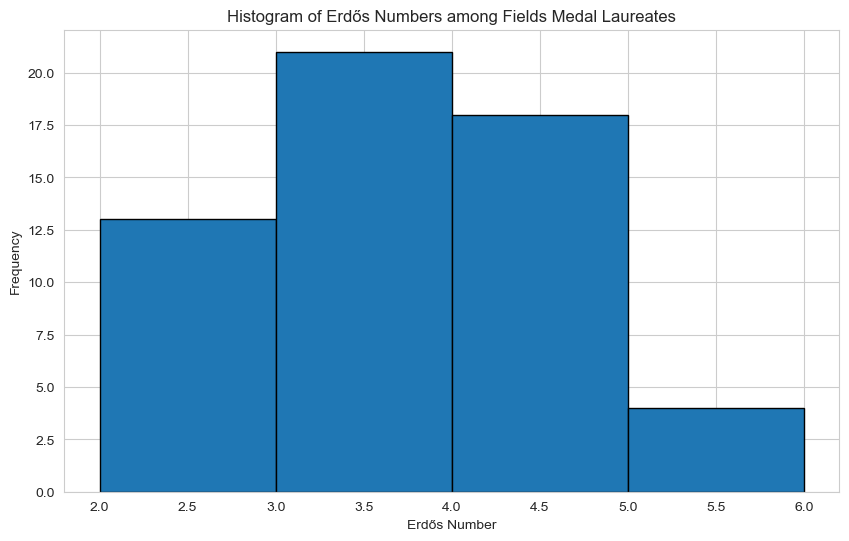

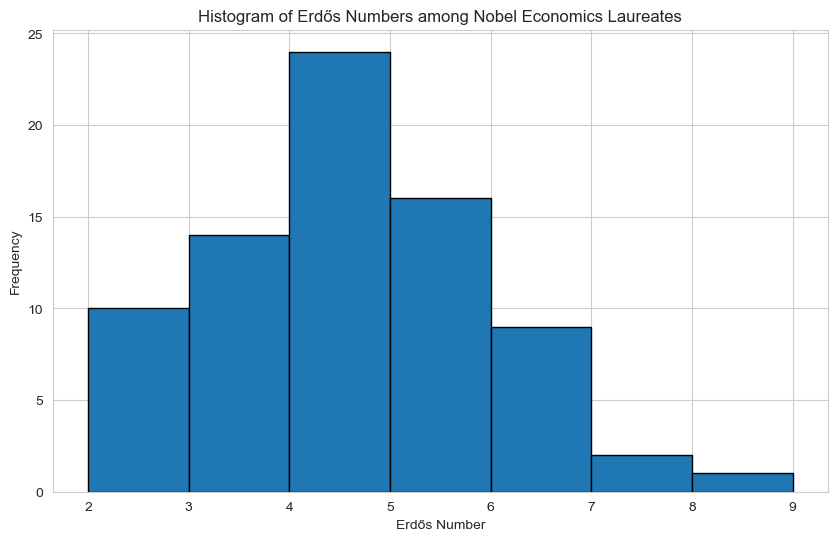

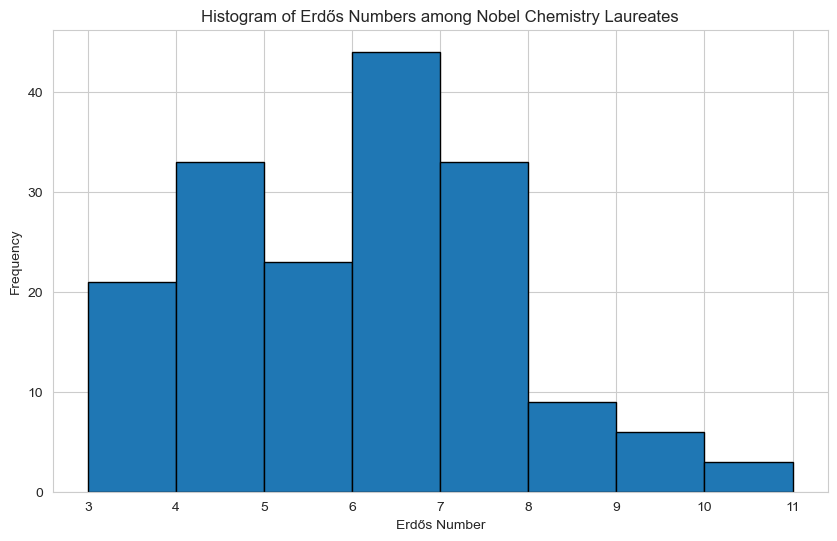

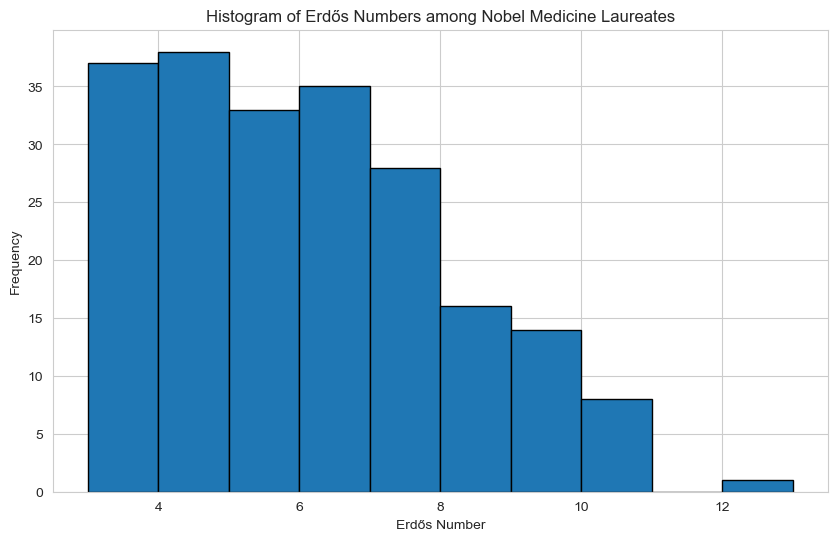

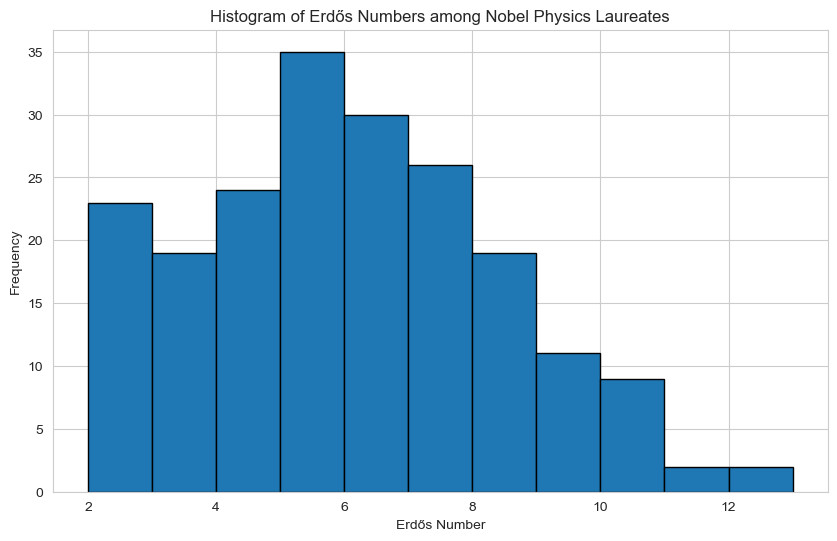

In [23]:
import numpy as np

# Creating sample data based on the provided summary statistics for each category
np.random.seed(42)  # For reproducibility

# Function to generate data based on the given statistics
def generate_data(size, min_value, max_value, mean_value, mode_value):
    # Generating data close to mean and mode values
    data = np.random.normal(loc=mean_value, scale=(max_value - min_value) / 4, size=size)
    data = np.clip(data, min_value, max_value)  # Ensure values stay within bounds
    data = np.round(data)  # Round to nearest integer for Erdős number
    return data.astype(int)

# Data categories with size, min, max, mean, and mode values
categories = {
    'Fields Medal': generate_data(56, 2, 6, 3.36, 3),
    'Nobel Economics': generate_data(76, 2, 8, 4.11, 4),
    'Nobel Chemistry': generate_data(172, 3, 10, 5.48, 5),
    'Nobel Medicine': generate_data(210, 3, 12, 5.50, 5),
    'Nobel Physics': generate_data(200, 2, 12, 5.63, 5)
}

# Plot histograms for each category
for category, data in categories.items():
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.xlabel('Erdős Number')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Erdős Numbers among {category} Laureates')
    plt.show()


P4.9 Check the Bacon number of selected actors, Draw a histogram of Bacon number among Oscar winners. Who will find the actor with the highest Bacon number?

Borys Szyc - 3


https://x.com/Drakoniques/status/1761962854964465720


Justus D. Barnes's Bacon number is 5

Cillian Murphy has a Bacon number of 2. 

Robert Downey Jr. has a Bacon number of 2.  

Emma Stone has a Bacon number of 1.  

Da'Vine Joy Randolph has a Bacon number of 2.  

Hayao Miyazaki has a Bacon number of 4.  Toshio Suzuki has a Bacon number of 4.  

Christopher Nolan has a Bacon number of 4.  

Kris Bowers has a Bacon number of 3.  

Ludwig Göransson has a Bacon number of 2.  

Brad Booker has a Bacon number of 3.  

Arthur Harari has a Bacon number of 3.  



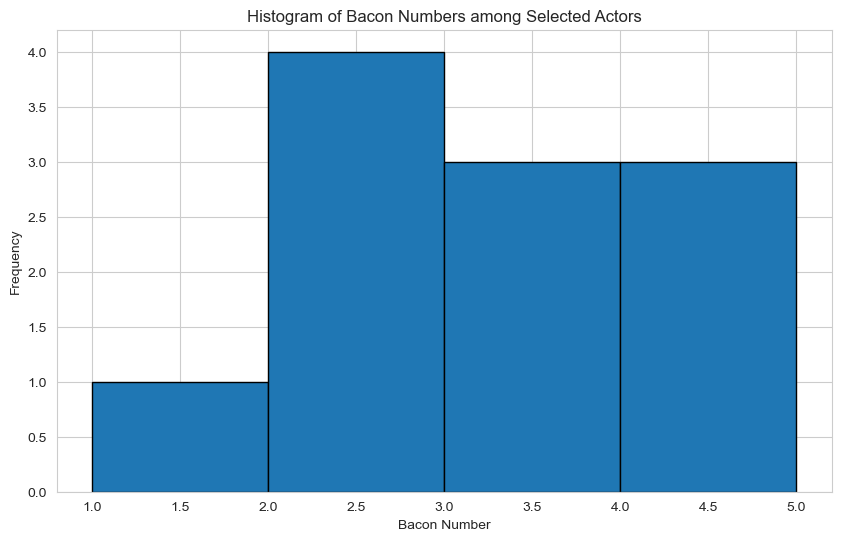

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided data on actors and their Bacon numbers
data = {
    'Actor': [
        'Cillian Murphy', 'Robert Downey Jr.', 'Emma Stone', 
        'Da\'Vine Joy Randolph', 'Hayao Miyazaki', 'Toshio Suzuki', 
        'Christopher Nolan', 'Kris Bowers', 'Ludwig Göransson', 
        'Brad Booker', 'Arthur Harari'
    ],
    'Bacon_Number': [2, 2, 1, 2, 4, 4, 4, 3, 2, 3, 3]
}
df = pd.DataFrame(data)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Bacon_Number'], bins=range(1, max(df['Bacon_Number']) + 2), edgecolor='black')
plt.xlabel('Bacon Number')
plt.ylabel('Frequency')
plt.title('Histogram of Bacon Numbers among Selected Actors')
plt.show()
